In [4]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import dask.dataframe as dd
import seaborn as sns
pd.set_option('display.max_rows', 10)
!date

%load_ext autoreload
%autoreload 2

/home/sam/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Sun Jun 23 20:06:31 EDT 2019


In [5]:
newnames={'TABBLKST':'STATE','TABBLKCOU':'COUNTY','ENUMDIST':'DIST','RTYPE':'GQ','QAGE':'AGE','CENHISP':'HISP','CENRACE':'RACE'}

In [6]:
def extract_epsilon(df):
    s = df.reset_index().path.astype(str)
    def get_eps(m):
        eps=m.split('_E')[1].split('_R')[0]
        if float(eps)>20:
            return float(eps)/100
        else:
            return float(eps)
    return s.map(get_eps).values

In [7]:
def extract_replicate(df):
    s = df.reset_index().path.astype(str)
    def get_rep(m):
        return  m.split('_E')[1].split('_R')[1]
    return s.map(get_rep).values
#t['i'] = extract_replicate(t)
#t

In [17]:
def plot_race(race_num, race_name, state, cef, t):
    plt.axhline(len(cef[cef.RACE==race_num]), color='k', linestyle='--')
    plt.text(8.5, len(cef[cef.RACE==race_num]), 'Exact Value', va='center', ha='left')

    plt.plot(t.epsilon, t[race_num], 'o', mec='C0', mew=1, color='none')
    #plt.xticks(1+np.arange(len(t.epsilon.unique())), t.epsilon.unique())
    plt.xlabel('Privacy Budget (epsilon)')
    plt.ylabel('Size of Population')
    plt.title(f'Number of {race_name} People in {state} in 1940');

In [9]:
# Run for GA
state='GA'

In [10]:
df = dd.read_csv(f'data/{state}/{state}_E*', include_path_column=True, usecols=[1,2,3,4,5,6,7], sep='\t')
df=df.rename(columns=newnames)
assert np.all(df.COUNTY % 10 == 0)
df['COUNTY'] = (df['COUNTY']/10).astype(int)

/home/sam/anaconda3/lib/python3.6/site-packages/dask/dataframe/io/csv.py:252: FutureWarning: float codes will be disallowed in the future and raise a ValueError
  colname: pd.Categorical.from_codes(np.zeros(len(head)), paths)


In [11]:
cef = pd.read_csv(f'data/{state}/the_real_{state}', usecols=[1,2,3,4,5,6,7], sep='\t')
cef.rename(columns=newnames, inplace=True)
assert np.all(cef.COUNTY % 10 == 0)
cef['COUNTY'] = (cef['COUNTY']/10).astype(int)

In [12]:
t = df.groupby('path').RACE.apply(lambda s: s.value_counts(), meta=('x', 'f8')).compute()
t=t.unstack()
t['epsilon']=extract_epsilon(t)
t['run']=extract_replicate(t)

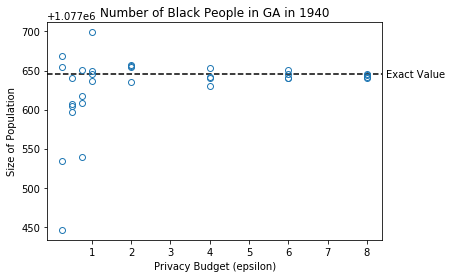

In [16]:
plot_race(2, 'Black', state, cef, t)

In [20]:
c = df.groupby(['path', 'COUNTY']).HISP.count().compute()
c.name = 'dp_count'
c = c.reset_index()
c['i'] = extract_replicate(c)
c['epsilon'] = extract_epsilon(c)

In [22]:
exact_val = cef.groupby('COUNTY').size()
exact_val.name = 'exact_count'
tt=pd.merge(c, exact_val.reset_index(), on='COUNTY')
tt['dp - exact'] = tt.exact_count - tt.dp_count

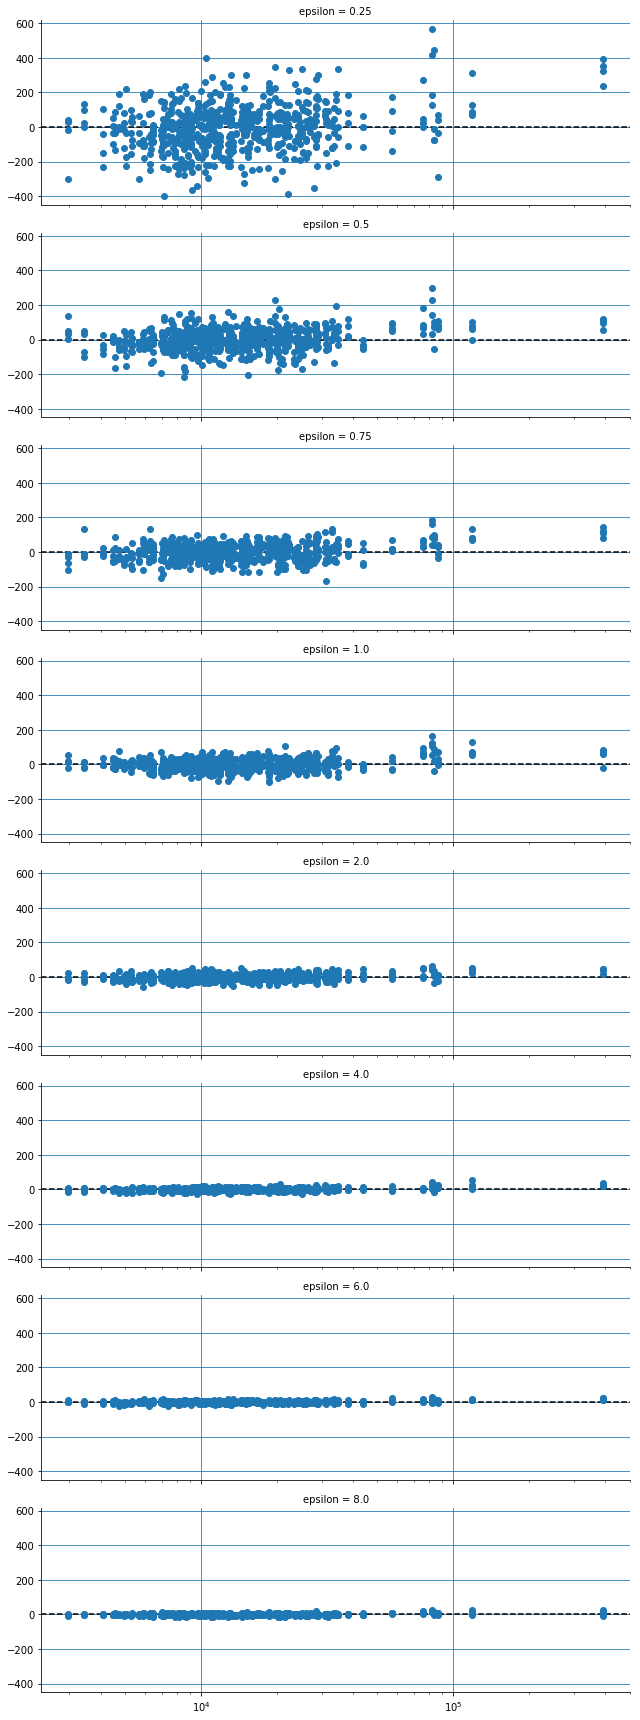

In [24]:
g = sns.FacetGrid(tt, row='epsilon', aspect=3)
g.map(plt.axhline, y=0, linestyle='--', color='k')
g.map(plt.semilogx, 'exact_count', 'dp - exact', marker='o', linestyle='none')
g.map(plt.grid, b=True);

/home/sam/anaconda3/lib/python3.6/site-packages/dask/dataframe/io/csv.py:252: FutureWarning: float codes will be disallowed in the future and raise a ValueError
  colname: pd.Categorical.from_codes(np.zeros(len(head)), paths)


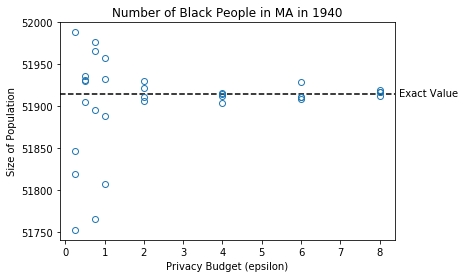

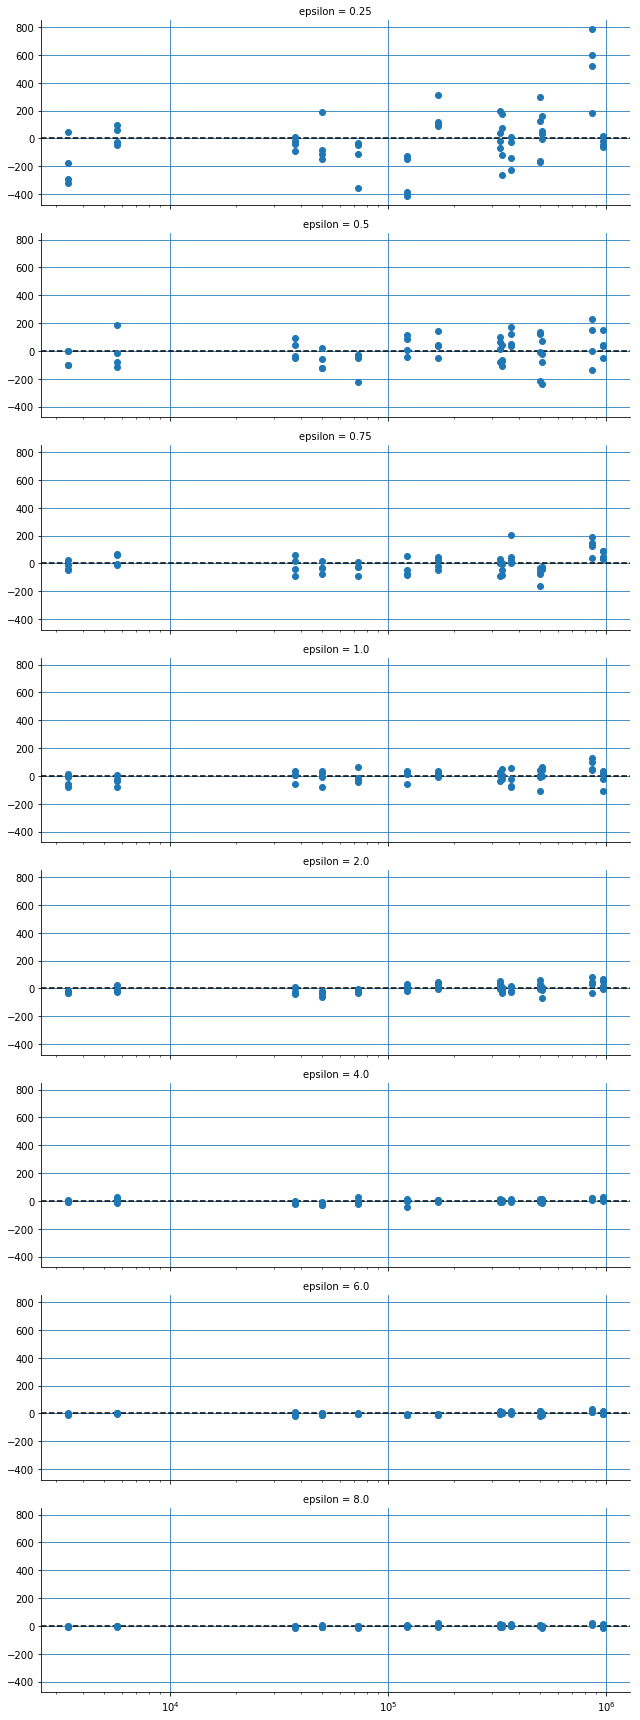

In [9]:
# Run for MA
state='MA'

df = dd.read_csv(f'data/{state}/{state}_E*', include_path_column=True, usecols=[1,2,3,4,5,6,7], sep='\t')
df=df.rename(columns=newnames)
assert np.all(df.COUNTY % 10 == 0)
df['COUNTY'] = (df['COUNTY']/10).astype(int)

cef = pd.read_csv(f'data/{state}/the_real_{state}', usecols=[1,2,3,4,5,6,7], sep='\t')
cef.rename(columns=newnames, inplace=True)
assert np.all(cef.COUNTY % 10 == 0)
cef['COUNTY'] = (cef['COUNTY']/10).astype(int)

t = df.groupby('path').RACE.apply(lambda s: s.value_counts(), meta=('x', 'f8')).compute()
t=t.unstack()
t['epsilon']=extract_epsilon(t)
t['run']=extract_replicate(t)

plot_race(2, 'Black', state, cef, t)

c = df.groupby(['path', 'COUNTY']).HISP.count().compute()
c.name = 'dp_count'
c = c.reset_index()
c['i'] = extract_replicate(c)
c['epsilon'] = extract_epsilon(c)

exact_val = cef.groupby('COUNTY').size()
exact_val.name = 'exact_count'
tt=pd.merge(c, exact_val.reset_index(), on='COUNTY')
tt['dp - exact'] = tt.exact_count - tt.dp_count

g = sns.FacetGrid(tt, row='epsilon', aspect=3)
g.map(plt.axhline, y=0, linestyle='--', color='k')
g.map(plt.semilogx, 'exact_count', 'dp - exact', marker='o', linestyle='none')
g.map(plt.grid, b=True);